# Finite Rate of Innovation (FRI) introduction

In this notebook, we provide an introductory tutorial on the Finite Rate of Innovation (FRI), based on the following paper ([IEEE link](https://ieeexplore.ieee.org/document/1003065/)):

    M. Vetterli, P. Marziliano and T. Blu, "Sampling signals with finite rate of innovation," in IEEE Transactions 
    on Signal Processing, vol. 50, no. 6, pp. 1417-1428, Jun 2002.
    
The purpose is to breakdown the underlying concept and sampling approach in an intuitive fashion, i.e. with code and clear explanations. In this notebook, we will consider the **_noiseless baseband_** case as to develop the intuition behind FRI. In another notebook, we will tackle _modulated_ and _noisy_ situations. For a more rigorous treatment, please refer to the paper!

In [1]:
import numpy as np
import sys
sys.path.append('..')
import plot_settings
from frius import create_pulse_param, sample_ideal_project, estimate_fourier_coeff, compute_ann_filt

# 1. Projecting to bandlimited space prior to sampling

The fundamental Nyquist-Shannon sampling theorem sets a lower bound on the sampling rate in order to perfectly recover **_bandlimited signals_**, i.e. signals of finite frequency support: "if a function $ f(t) $ contains no frequencies higher than $ f_m $ Hz, it is completely determined by giving its ordinates at a series of points spaced $ (1/2f_m) $ seconds apart" [1].

If the signal we would like to sample is not bandlimited, we can first **_project_** it to a bandlimited space by applying a lowpass filter with the appropriate cut-off frequency. Assume that we are able to use a very simple (but very ideal) low-pass filter $ s_B(t) $, whose frequency response can be written as:

\begin{align}
	\hat{s}_B(f) = 
	\begin{cases}
	1/B, & f\in[-B/2, B/2]   \\[0.5em]
	0,      & \text{otherwise},  \\
	\end{cases}
\end{align}

where the amplitude is $ (1/B) $ so that we have unit norm, $ \|\hat{s}_B(f)\|_2 = 1 $. An example of such a filter can be seen below. The purpose of this filter is to prevent aliasing, which is why it is often called an **_anti-aliasing_** filter.

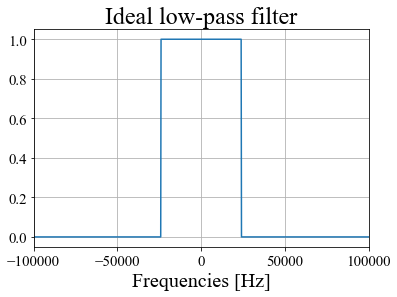

In [2]:
# create ideal low-pass filter
cutoff = 24000
n_vals = 1000
freqs = np.linspace(-1e5, 1e5, 1000)
lpf = np.ones(n_vals)
lpf[freqs<-cutoff] = 0
lpf[freqs>cutoff] = 0

plt.title("Ideal low-pass filter")
plt.plot(freqs, lpf)
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequencies [Hz]");

By taking the inverse Fourier Transform (FT), we can express $ \hat{s}_B(f) $ in the time-domain as:

\begin{align}
\label{eq:ideal_lp_time}
s_B(t) = \text{sinc}(Bt),
\end{align}

where $ \text{sinc}(t)=\sin(\pi t)/\pi t $. 

After applying our ideal projection/filter to our input signal, the maximum frequency has been set to $ f_m = B/2 $. So according to Nyquist-Shannon, in order to sample the _now bandlimited signal_ so that it can be perfectly reconstructed from the measured samples, it is necessary to obtain samples at every $T_s = (1/B)$ seconds (or less), i.e. sample it at a rate $ f_s \geq B$~Hz. We will refer to **_critical sampling_** as the case where we obtain just enough samples for perfect reconstruction. We can combine our filtering with critical sampling as such:

\begin{align}
	y_{BL}[n] &= y_{BL}(nT_s) \nonumber\\[0.05cm]
	&= (y \ast s_B)(u)|_{u = nT_s} \nonumber \\
	&= \int_{-\infty}^{\infty} y(t) \hspace{0.05cm}  s_B(nT_s-t) dt \nonumber\\
	&= \int_{-\infty}^{\infty} y(t) \hspace{0.05cm} \text{sinc}\Big(B(nT_s-t)\Big) dt \nonumber\\
	&= \int_{-\infty}^{\infty} y(t) \hspace{0.05cm} \text{sinc}\Big(\dfrac{nT_s-t}{T_s}\Big)  dt,\nonumber
\end{align}  

where $ n \in \mathbb{Z} $ and we use that $ T_s=(1/B) $ for our critical sampling case. We can equally express the above critical sampling in a single line as an inner product:

\begin{align}
y_{BL}[n] = \langle y, \tilde{\varphi }_n \rangle,
\end{align} 

if we set $ \tilde{\varphi}_n(t) = \text{sinc}\big((nT_s-t)/T_s\big) $. 

# 2. Bandlimited reconstruction 

 We can then perfectly reconstruct the best bandlimited approximation $ y_{BL}(t) $, in a least-squares sense, of our original non-bandlimited signal from our samples $ y_{BL}[n] $ as such:

\begin{align}
 y_{BL}(t) &= \sum_{n\in\mathbb{Z}} y_{BL}[n] \hspace{0.05em} \text{sinc}\Big(\dfrac{t - nT_s}{T_s}\Big).
 \end{align}

Equivalently, if we let $ \varphi_n(t) = \tilde{\varphi}_n(-t) = \text{sinc}\big((t - nT_s)/T_s\big)$ and use our inner product notation from before, we can write the whole sampling _and_ reconstruction process in one shot!

 \begin{align}
 	y_{BL}(t) &=\sum_{n\in\mathbb{Z}} \langle y, \tilde{\varphi }_n \rangle \hspace{0.05em} \varphi_n.
 \end{align}

If $ y(t) $ was already bandlimited to $ [-B/2,B/2] $, then $ y_{BL}(t) =y(t) $, reinforcing our idea of sampling and reconstruction as a projection, due to the process being idempotent. We can also observe that our optimal reconstruction filter $ \varphi_n $ and the anti-aliasing operation $ \tilde{\varphi}_n $ are flipped versions of each other for perfect recovery. This is due to $ \varphi_n $ being orthonormal to its integer shifts of $ T_s $: $ \langle \varphi_n, \varphi_k \rangle = \delta_{n-k} $. 

# 3. Generalizing the projection operation

We can interpret $ \varphi(t) = \text{sinc}(Bt) $ as a **_generating function_** for the bandlimited space $ [-B, B] $ as it allows us to construct any signal in this space with the appropriate shifts and weights of $ \varphi(t) = \text{sinc}(Bt) $. In [2], this generating function idea was extended to other functions that allow for sampling and reconstruction with more _practical_ choices of $ \varphi(t) $, i.e. those with a much faster decay than $ \text{sinc}(t) $ and with compact support. One idea was to relax the orthonormal requirement, e.g. with splines which can approximate polynomials up until a certain degree very well. In ou bandlimited reconstruction, we specifically saw the best approximation in the bandlimited space, which corresponds to a basis of shifted sinc functions. This idea can be extended to a different generating function at integer shifts of $ T_s $, i.e. uniform samples, for which we can denote the approximation in this $ \varphi_n(t)$ basis as $y_{\varphi}(t)$, namely:

\begin{align}
 	y_{\varphi}(t) &=\sum_{n\in\mathbb{Z}} \langle y, \tilde{\varphi }_n \rangle \hspace{0.05em} \varphi_n.
\end{align}

# 4. The "rate of innovation" perspective

Another extension made by [3] is to consider the **_degrees of freedom per unit of time_**, for which the authors coined the term **_rate of innovation_**. For our bandlimited reconstruction, Nyquist-Shannon required us to have samples spaced $ (1/B) $ seconds apart, if the bandwidth of our input signal to limited to $ B $. This implies a **_finite_** rate of innovation (FRI) of $ \rho = B = (1/T_s) $, or $ \rho = (1/2f_m) $ when expressed in terms of the maximum frequency. On the other hand, an arbitrary non-bandlimited signal could have an _infinite_ rate of innovation. 

Continuing with the narrative of [3], we can write our sampling and reconstruction for at _arbitrary_ shifts $ t_n $ instead of integer shifts of $ T_s $:

\begin{align}
    y_{\varphi}(t)  &= \sum_{n\in\mathbb{Z}} \langle y, \tilde{\varphi }_n \rangle \hspace{0.05em} \varphi_n \nonumber\\
 \Rightarrow 	y_{\varphi}(t) &= \sum_{n\in\mathbb{Z}} c_n \hspace{0.05em} \varphi\Big(\dfrac{t - t_n}{T_s}\Big),
\end{align}

where we now express $ \langle y, \tilde{\varphi }_n \rangle $ as coefficients $ c_n $ for our shifted generating functions (as was also done in [2]). From the more general expression above, we are interested in the conditions for which the approximation $ y_{\varphi}(t)  $ perfectly matches the original signal $ y(t) $. For the bandlimited case, we have the following "ingredients":

1. $ y(t) $ is bandlimited to $ B $; if not we make it bandlimited and are able to perfectly reconstruct this bandlimited version.
2. $ c_n $ are samples taken at every $ T_s = (1/B) $ seconds.
3. $ \varphi(t) = \text{sinc}(Bt) $, which will be "placed" at integer shifts of $ T_s $. 

However, in certain cases can we do better than a bandlimited approximation? In other words, can we achieve perfect reconstruction of $ y(t) $ in a situation deemed "impossible" according to the Nyquist-Shannon sampling theorem? Consider a single Dirac which has **_infinite bandwidth_**:

\begin{align}
y(t) = \delta(t-t_0) \xrightarrow{\mathscr{F}} \hat{y}(f) = \exp(-j2\pi f t_0).
\end{align}

We would certainly be able to sample and reconstruct a bandlimited version of this signal according to Nyquist-Shannon, where an anti-aliasing filter/generating function pair with larger and larger bandwidth would allow us to obtain an increasingly better bandlimited approximation. But determining the precise location $ t_0 $ of the Dirac would certainly be a much more faithful representation! Similarly, we can consider a $ T $-periodic sum of $ K $ known pulses $ h(t) $:

\begin{align}
y(t) = \sum_{n\in\mathbb{Z}}\sum_{k=0}^{K-1}c_k \hspace{0.05cm} h(t-t_k-nT),
\end{align}

where in the single Dirac case we simply had $ h(t)=\delta(t) $ and $ K=1 $. If we instead have a pulse stream over a finite duration $ T $, we can define it as $ T $-periodic as by simply repeating the signal at every $ T $ seconds. It does not make a significant difference for the recovery process that will be presented below, as it works on one period of the signal. 

A noteworthy observation we can make about the above **_pulse stream_** signal is that given we know the pulse shape $ h(t) $, there are only $2K$ degrees of freedom per period: the $K$ locations $\{t_k\}_{k=0}^{K-1}$ and the $K$ amplitudes $\{c_k\}_{k=0}^{K-1}$. We have, however, made a few __very strong__ assumptions:

1. Our signal consists of exactly $ K $ pulses.
2. We know the exact shape of the pulse.
3. There is only one pulse shape.

In the general bandlimited case, our only assumption was that our signal had (essentially) no frequency content above a certain maximum frequency $ f_m$. If not, we apply an anti-aliasing filter to project the signal onto a known bandlimited space. Nevertheless, if our pulse stream model assumption is correct, we can safely say that there are $ 2K $ degrees of freedom per period $ T $, implying an FRI of $ \rho = (2K/T) $. 

In [3], a method for recovering the unknown finite parameters of a pulse stream is presented in the noiseless scenario. In the remainder of this notebook, we look at how this recovery is performed.

# 5. Pulse stream recovery

As in the bandlimited case, we will obtain samples of our pulse stream after it has gone through a sampling kernel $ s_B(t) $, which may or may not be of our choosing. 

## Sampling requirements

Moreover, for pulse stream recovery, we require:

1. The bandwidth $ B $ of our sampling kernel $ s_B(t) $ to be greater than and or equal to the rate of innovation $ \rho $.
2. $ N \geq (2M+1) $ uniform samples where $ M = \lfloor BT/2 \rfloor $. Moreover, the sampling period should be $ T_s = T/N $.

As for the bandlimited case, we will require a sampling kernel with bandwidth $ B \geq \rho $. For critical sampling of a pulse stream signal, this corresponds to $ B = (2K/T) $, where $ K $ is the number of pulses and the $ T $ is the period of the signal. 

In the bandlimited scenario, we then require samples at every $ T_s = (1/B) $ seconds. For pulse stream recovery, in order to use real-valued sampling kernels, i.e. $ \hat{s}_B(f) $ being conjugate symmetric, we will need to meet the second condition above, yielding the following samples:

\begin{align}
y_{BL}[n] &= y(nT_s)  =\langle y(t), s_B(nT_s - t) \rangle \nonumber\\
&= \langle y(t), \text{sinc}\big((nT_s-t)B\big)  \rangle  \text{ for }  n\in[0, 1, \ldots, \mathrel{{N}{-}{1}}],\nonumber
\end{align} 

where we again assume an ideal sampling kernel as in the bandlimited case presented before.

## Recovery in code and visuals

With these samples, the recovery boils to determining a **_mask_** whose zeros coincide precisely with the location of the pulses. 

Below we consider a pulse stream with six _Diracs_ that goes through a sampling kernel that meets the above requirements. In other words, are signal has the following form:

\begin{align}
y(t) = \sum_{n\in\mathbb{Z}}\sum_{k=0}^{K-1}c_k \hspace{0.05cm} \delta(t-t_k-nT),
\end{align}

where $K=6$ and for this example we will set $T=1$. Consequently $y(t)$ goes through a sampling kernel with the following frequency response.

\begin{align}
	\hat{s}_B(f) = 
	\begin{cases}
	1/B, & f\in[-B/2, B/2]   \\[0.5em]
	0,      & \text{otherwise},  \\
	\end{cases}
\end{align}

where $B=2K/T$, i.e. a filter with the minimum bandwidth possible for recovery. Finally, we obtain $N=2K+1$ samples, corresponding to a sampling rate of $f_s = (2K+1)/T$.

Below, we start off by creating and signal parameters and synthesize the lowpass filtering and sampling. See 'frius/fri_utils.py' for the definitions of the used functions.

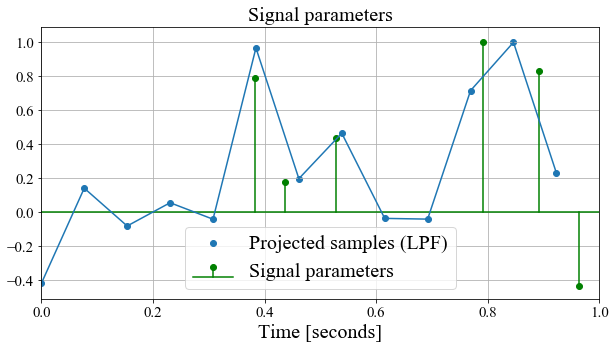

In [3]:
K = 6
period = 1
ck, tk = create_pulse_param(K=K, period=period)
y_samp, t_samp, fs_ind_base = sample_ideal_project(ck, tk, period=period, viz=True, figsize=(10,5))

The novelty in the pulse stream recovery algorithm of [3] is in identifying the "mapping" between our measured samples and values with which we can determine this **_mask_** that will lead us to the pulse stream parameters. This idea can be generalized to models different than the pulse stream we are considering here, as are also discussed in [3] and [4].

For the pulse stream signal, the FT of our samples yield us the samples that will allow us to determine the mask, which is also referred to as the **_annihilating filter_**.

In [4]:
fs_coeff_hat = estimate_fourier_coeff(y_samp, t_samp)
ann_filt = compute_ann_filt(fs_coeff_hat, K)

The term "annihilation" arises from the fact that when we convolve our annihilating filter with the Fourier coefficients of the measured samples, the resulting output will be zero, i.e. annihilated!

In [5]:
print("ann_filt conv fs_coeff_hat = ", np.abs(np.convolve(ann_filt, fs_coeff_hat, mode='valid')))

ann_filt conv fs_coeff_hat =  [  3.12639119e-13   2.64074429e-14   1.18856725e-13   4.61886137e-14
   1.15667977e-13   2.89169943e-14   3.79429987e-15]


Moreover, we can observe that the zeros of our mask (the time domain representation of the annihilating filter) coincide exactly with the zeros of our pulse stream!

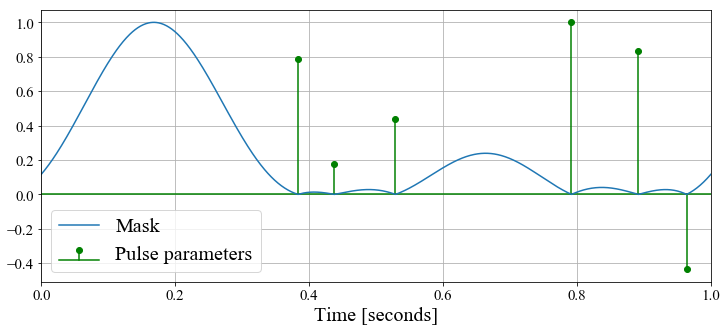

In [6]:
# annihilating filter in time domain
t_vals = np.linspace(0., period, num=1000, endpoint=True)
z = np.exp(-1j*2*np.pi*t_vals/period)
mask = np.abs(np.polyval(ann_filt, z))
mask /= max(mask)

# plot
plt.figure(figsize=(12,5))
baseline = plt.stem(tk, ck/max(abs(ck)), 'g', markerfmt='go', label="Pulse parameters")[2]
plt.setp(baseline, color='g')
baseline.set_xdata([0, period])
plt.xlim([0,period])
plt.grid()
plt.xlabel("Time [seconds]")
plt.plot(t_vals, mask, label="Mask")
plt.legend(loc='lower left');

Therefore, recovering the locations of our pulses, $\{t_k\}_{k=0}^{K-1}$, corresponds precisely to determining the zeros of this mask!

In [7]:
uk = np.roots(ann_filt)
uk = uk / np.abs(uk)                                         # project to unit circle
tk_hat = np.real(1j * period * np.log(uk) / (2 * np.pi))     # invert "mapping" to get to parameters  
tk_hat = tk_hat - np.floor(tk_hat / period) * period         # ensure location within [0, period]
tk_hat = np.sort(tk_hat)                                     # sort for comparison as `tk` are sorted
print("||tk - tk_hat||_2 = %f " % np.linalg.norm(tk-tk_hat))

||tk - tk_hat||_2 = 0.000000 


The function 'estimate_time_param' in 'frius/fri_utils.py' implements the above code snippet.

Once we know the pulse locations, determining the amplitudes of the pulses, $\{c_k\}_{k=0}^{K-1}$, can be cast as a least-squares problem by "placing" the pulses at the recovered positions, forming the forward matrix between the amplitudes and the measured samples.

We can also perform the "fitting" in the frequency domain as is done below. Moreover, the Fourier coefficient indices divided by the period yields the corresponding frequency values in Hertz.

In [8]:
tk_grid, freqs_grid = np.meshgrid(tk_hat, fs_ind_base/period)
Phi = np.exp(-1j*2*np.pi*freqs_grid*tk_grid)/period             # forward matrix A in y=Ax
ck_hat = np.real(lstsq(Phi, fs_coeff_hat)[0])                   # 'fs_coeff_hat' corresponds to 'y'
print("||ck - ck_hat||_2 = %f " % np.linalg.norm(ck-ck_hat))

||ck - ck_hat||_2 = 0.000000 


The function 'estimate_amplitudes' in 'frius/fri_utils.py' implements the above code snippet.

## Recovery steps

Assuming the above sampling requirements have been met, we can use the following procedure to recover the $2K$ parameters of an (ideal) lowpass filtered **_Dirac_** stream with $K$ pulses [3]:

1. With the samples, estimate the Fourier coefficients with the DFT, as done with the function 'estimate_fourier_coeff' in 'frius/fri_utils.py'.
2. Obtain the annihilating filter for the Fourier coefficients. See [3] for a mathematical description and 'compute_ann_filt' in 'frius/fri_utils.py' for implementation details. 
3. Find the $K$ zeros of the mask corresponding to the annihilating filter. This will yield the locations $\{t_k\}_{k=0}^{K-1}$.
4. With the locations and measured samples, solve a least-squares for the pulse amplitudes $\{c_k\}_{k=0}^{K-1}$.

We place an emphasis on **_Dirac_**, as an additional step needs to be performed **_before_** determining the annihilating filter in order to work with arbitrary pulse shapes. This will be discussed in the next notebook!

# References

    [1] C. E. Shannon. “Communication in the Presence of Noise”. In: Proceedings of the IRE 37 (1949), pp. 10–21.
    [2] M. Unser. “Sampling-50 years after Shannon”. In: Proceedings of the IEEE 88 (2000), pp. 569–587.
    [3] M. Vetterli, P. Marziliano and T. Blu, "Sampling signals with finite rate of innovation," in IEEE Transactions on Signal Processing, vol. 50, no. 6, pp. 1417-1428, Jun 2002.
    [4] P. L. Dragotti, M. Vetterli and T. Blu, "Sampling Moments and Reconstructing Signals of Finite Rate of Innovation: Shannon Meets Strang–Fix," in IEEE Transactions on Signal Processing, vol. 55, no. 5, pp. 1741-1757, May 2007.